# Emerging Methods For Early Detection Of Forest Fires

Dataset Link: https://www.kaggle.com/datasets/arbethi/forest-fire?select=Dataset

In [1]:
import os
from os import path
from pathlib import Path
from matplotlib import pyplot

In [2]:
!unzip "dataset.zip" -d "content"

Archive:  dataset.zip
   creating: content/Dataset/test_set/
   creating: content/Dataset/test_set/forest/
  inflating: content/Dataset/test_set/forest/_101542074_gettyimages_956391468.jpg  
  inflating: content/Dataset/test_set/forest/0.48007200_1530881924_final_forest.jpg  
  inflating: content/Dataset/test_set/forest/0.64133000_1519374442_forest_deep.jpg  
  inflating: content/Dataset/test_set/forest/0.72918000_1559733279_forests1_gettyimages_.jpg  
  inflating: content/Dataset/test_set/forest/0.98884800_1554454572_spin.jpg  
  inflating: content/Dataset/test_set/forest/01_NeilBurnell_Mystical_photoverticall.jpg  
  inflating: content/Dataset/test_set/forest/091318_LH_forest_loss_main_FREE.jpg  
  inflating: content/Dataset/test_set/forest/1_chimp.jpg  
  inflating: content/Dataset/test_set/forest/1009821.jpg  
  inflating: content/Dataset/test_set/forest/111188170_river_in_the_mountain_forest.jpg  
  inflating: content/Dataset/test_set/forest/1170x500_Ireland_web.jpg  
  inflating:

In [3]:
DATASET_PATH: str = path.join(Path(path.abspath("")), "content", "dataset")
MODEL_PATH: str = path.join(Path(path.abspath("")), "model", "forest_fire.h5")

### Data Augumentation

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
training_image_generator: ImageDataGenerator = ImageDataGenerator(rescale=1/255, shear_range=0.2, rotation_range=180, zoom_range=0.2, horizontal_flip=True)
testing_image_generator: ImageDataGenerator = ImageDataGenerator(rescale=1/255)

In [6]:
training_images = training_image_generator.flow_from_directory(path.join(DATASET_PATH, "train_set"), target_size=(128, 128), batch_size=32, class_mode="binary")
testing_images = testing_image_generator.flow_from_directory(path.join(DATASET_PATH, "test_set"), target_size=(128, 128), batch_size=32, class_mode="binary")

Found 436 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


### Building the CNN Model

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [9]:
def ForestFireDetector() -> Sequential:
    model: Sequential = Sequential(name="ForestFireDetector")

    model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), name="Conv2D_01"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPooling2D_01"))
    model.add(Dropout(0.25, name="Dropout_01"))

    model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3), name="Conv2D_02"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPooling2D_02"))
    model.add(Dropout(0.25, name="Dropout_02"))
    model.add(Flatten(name="Flatten_01"))

    model.add(Dense(300, activation="relu", name="Dense_Relu_01"))
    model.add(Dense(150, activation="relu", name="Dense_Relu_02"))
    model.add(Dense(1, activation="sigmoid", name="Dense_Sigmoid"))

    return model

In [10]:
def train_model(override: bool = True) -> Sequential:
    if not override and path.exists(MODEL_PATH):
        return load_model(MODEL_PATH)  # type: ignore

    model: Sequential = ForestFireDetector()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()

    model.fit(training_images, steps_per_epoch=len(training_images), epochs=10, validation_data=testing_images, validation_steps=len(testing_images))
    model.save(MODEL_PATH)

    return model

In [11]:
model: Sequential = train_model(override=False)

### Testing the Model

In [12]:
import cv2
import numpy

from keras.utils import load_img, img_to_array

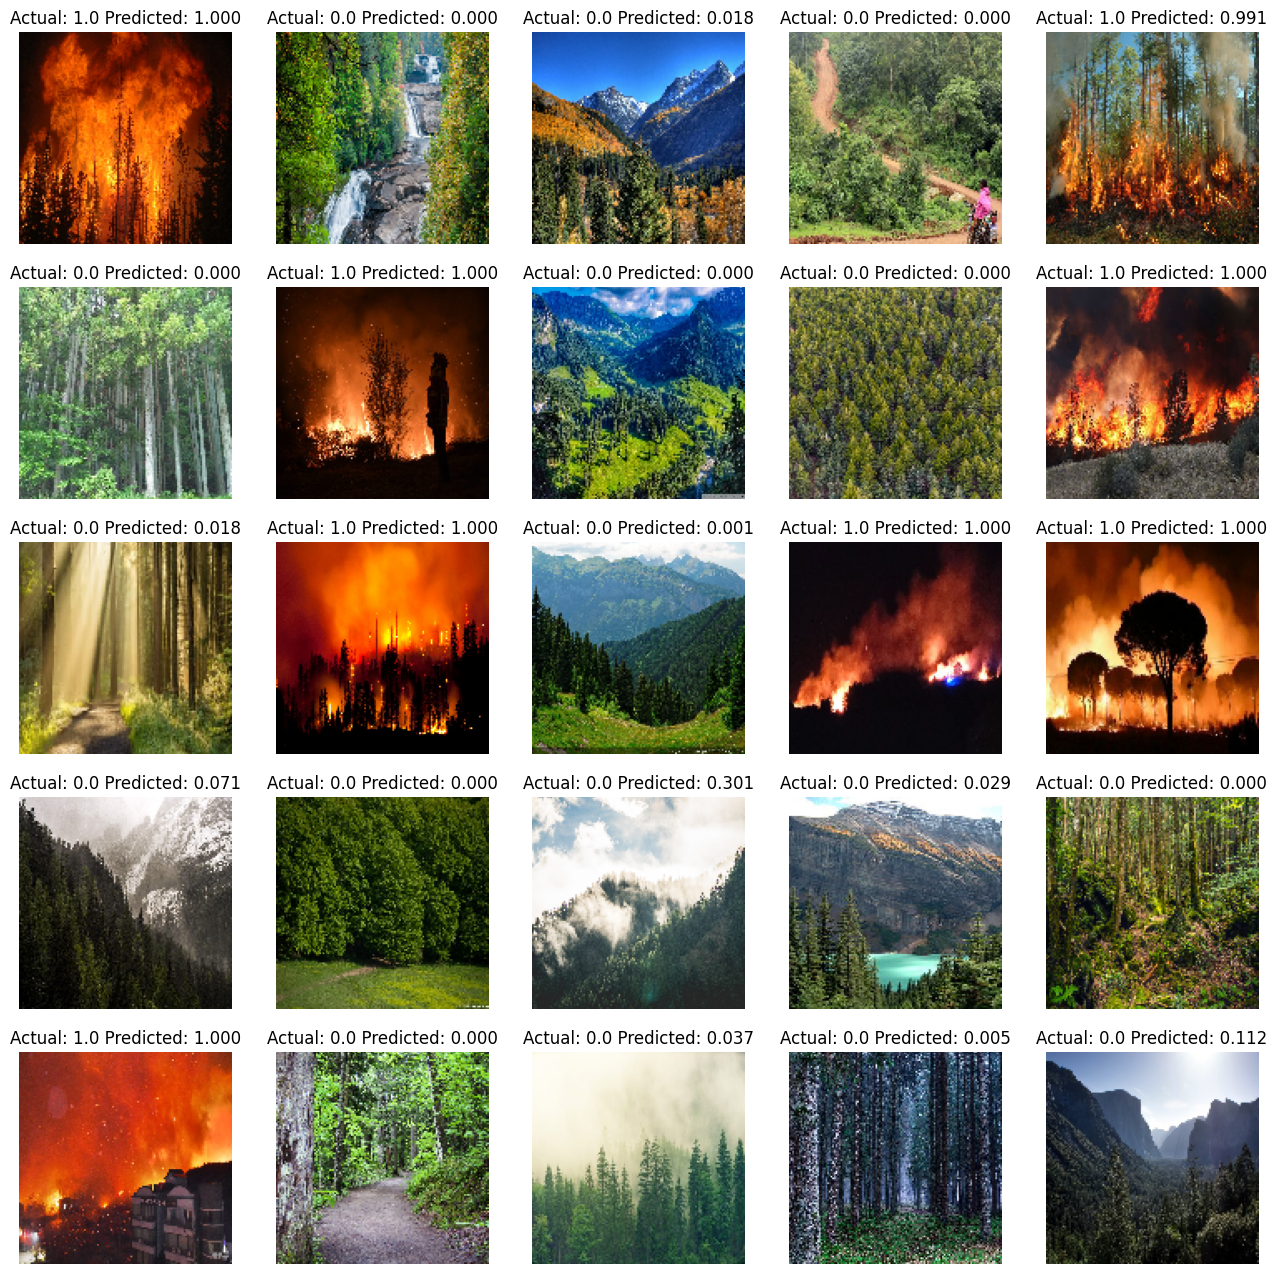

In [13]:
validation_images, validation_labels = testing_images.__getitem__(0)

predictions = model.predict(validation_images, verbose=0)

fig, axes = pyplot.subplots(5, 5, figsize=(16, 16))

for image, label, prediction, ax in zip(validation_images, validation_labels, predictions, axes.flatten()):
    ax.imshow(image)
    ax.set_title(f"Actual: {label} Predicted: {prediction[0]:0.3f}")
    ax.set_axis_off()

In [14]:
loss, accuracy = model.evaluate(validation_images, validation_labels, verbose="0")
print(f"Test set\n  Loss: {loss:0.3f}, Accuracy: {accuracy:0.3f}")

Test set
  Loss: 0.021, Accuracy: 1.000


### Video Processing

In [ ]:
import asyncio
from PIL import Image
from time import sleep
from threading import Thread
from playsound import playsound

In [ ]:
VIDEO_PATH = path.join(Path(path.abspath("")), "content", "forest.mp4")
AUDIO_PATH = path.join(Path(path.abspath("")), "content", "alert.wav")

In [ ]:
capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)
capturing: bool = True

while capturing and capture.isOpened():
    _, frame = capture.read()

    _frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(_frame, mode="RGB").resize((128, 128))
    image = numpy.expand_dims(img_to_array(image), axis=0)

    prediction = round(model.predict(image, verbose=0)[0][0])

    text = ["No Fire", "Fire"][prediction]
    font = cv2.FONT_HERSHEY_SIMPLEX

    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    x, y = (frame.shape[1] - textsize[0]) // 2, 100

    cv2.putText(frame, text, (x, y), font, 1, (41, 230, 63), 2)

    cv2.imshow("Fire Detection", frame)
    if prediction:
        playsound(AUDIO_PATH, block=False)

    if cv2.waitKey(1) == ord("q"):
        capturing = False

capture.release()
cv2.destroyAllWindows()